# Inverse problems

In this demo, we'll revisit the Larsen Ice Shelf.
This time, we're going to estimate the fluidity coefficient $A$ in Glen's flow law

$$\dot\varepsilon = A\tau^3$$

from observational data.
In the previous demos, we've come up with some value of the fluidity coefficient and computed a velocity field by solving an elliptic partial differential equation.
The fluidity coefficient is roughly a known function of the ice temperature, together with some fudge factors for crystal fabric or large-scale damage, so we know an approximate range of values that it could take.
Nonetheless, we don't have large-scale measurements of the fluidity coefficient from remote sensing like we do for ice velocity and thickness.

Instead, we can try to come up with a value of $A$ that gives a velocity field closest to what we observed.
This idea can be turned into a constrained optimization problem.
The quantity we wish to optimize is the misfit between the computed velocity $u$ and the observed velocity $u^o$:

$$E(u) = \frac{1}{2}\int_\Omega\left(\frac{u - u^o}{\sigma}\right)^2dx,$$

where $\sigma$ are the standard deviations of the measurements.

One constraint is that the fluidity field has to be positive.
Inequality constraints can require substantially more sophisticated numerical methods.
To avoid this problem, we'll cheat our way out by reparameterizing $A$ in terms of a new variable $\theta$:

$$A = A_0e^\theta.$$

No matter the value of $\theta$, $A$ is always positive.
To make this change, we'll give the `IceShelf` object our own custom-made function for calculating the viscous part of the action functional, just like we did for the friction in the last demo.

In addition to minimizing the misfit, we also want to have a relatively smooth value of the parameter field $\theta$.
The regularization functional $R$ is included to penalize oscillations of size $\Theta$ over a given length scale $L$:

$$R(\theta) = \frac{L^2}{2\Theta^2}\int_\Omega|\nabla \theta|^2dx.$$

Finally, let $F(u, \theta)$ be the weak form of the shallow shelf equations, again using the new parameter $\theta$ instead of the fluidity $A$.
The physics constraint for our problem is that $F(u, \theta) = 0$.
We can enforce this constraint by introducing the Lagrange multiplier $\lambda$, in which case the combined objective functional is

$$J(u, \theta; \lambda) = E(u) + R(\theta) + \langle F(u, \theta), \lambda\rangle.$$

We can calculate the derivative of this functional with respect to $\theta$ by using the *adjoint method*.
We can then use a descent method to iterate towards a critical point, which is hopefully close to the true value of the fluidity coefficient.

### Input data

The input data are the same as from the previous demo of the Larsen Ice Shelf.

In [1]:
import geojson
import icepack

outline_filename = icepack.datasets.fetch_outline('larsen')
with open(outline_filename, 'r') as outline_file:
    outline = geojson.load(outline_file)
    
geometry = icepack.meshing.collection_to_geo(outline)
with open('larsen.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

In [2]:
!gmsh -2 -format msh2 -v 2 -o larsen.msh larsen.geo

In [3]:
import firedrake
mesh = firedrake.Mesh('larsen.msh')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [4]:
import numpy as np
import rasterio
import icepack.plot

features = [feature['geometry'] for feature in outline['features']]
xmin, ymin, xmax, ymax = np.inf, np.inf, -np.inf, -np.inf
δ = 50e3
for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        x, y = xs[:, 0], xs[:, 1]
        xmin, ymin = min(xmin, x.min() - δ), min(ymin, y.min() - δ)
        xmax, ymax = max(xmax, x.max() + δ), max(ymax, y.max() + δ)
        
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
with rasterio.open(image_filename, 'r') as image_file:
    height, width = image_file.height, image_file.width
    transform = image_file.transform
    window = rasterio.windows.from_bounds(
        left=xmin, bottom=ymin, right=xmax, top=ymax,
        width=width, height=height, transform=transform
    )
    image = image_file.read(indexes=1, window=window, masked=True)

def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots(*args, **kwargs)
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    kw = {
        'extent': (xmin, xmax, ymin, ymax),
        'cmap': 'Greys_r',
        'vmin': 12e3,
        'vmax':16.38e3
    }
    try:
        axes.imshow(image, **kw)
    except AttributeError:
        for ax in axes:
            ax.imshow(image, **kw)
    
    return fig, axes

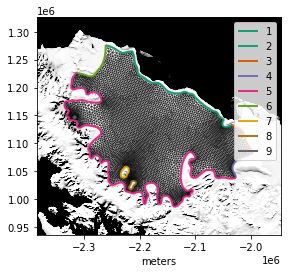

In [5]:
fig, axes = subplots()
axes.set_xlabel('meters')
kwargs = {
    'interior_kw': {'linewidth': .25},
    'boundary_kw': {'linewidth': 2}
}
icepack.plot.triplot(mesh, axes=axes, **kwargs)
axes.legend();

Just like in the 2nd demo, we'll apply the smoothing filter to the thickness, which is necessary to get a reasonable driving stress.

In [6]:
from firedrake import inner, grad, dx

thickness_filename = icepack.datasets.fetch_bedmachine_antarctica()
thickness = rasterio.open(f'netcdf:{thickness_filename}:thickness', 'r')

Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
h0 = icepack.interpolate(thickness, Q)

h = h0.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J = 0.5 * ((h - h0)**2 + α**2 * inner(grad(h), grad(h))) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

In addition to the velocities themselves, we also need the estimates of the velocity measurement errors.
The fidelity of the measurements tells us how good a fit to the data we should expect.

In [7]:
velocity_filename = icepack.datasets.fetch_measures_antarctica()
vx = rasterio.open(f'netcdf:{velocity_filename}:VX', 'r')
vy = rasterio.open(f'netcdf:{velocity_filename}:VY', 'r')
stdx = rasterio.open(f'netcdf:{velocity_filename}:ERRX', 'r')
stdy = rasterio.open(f'netcdf:{velocity_filename}:ERRY', 'r')

V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)
u_obs = icepack.interpolate((vx, vy), V)
σx = icepack.interpolate(stdx, Q)
σy = icepack.interpolate(stdy, Q)

Here we'll plot the velocity errors.
You can see from the stripey pattern that they depend on the particular swath from the observational platform.

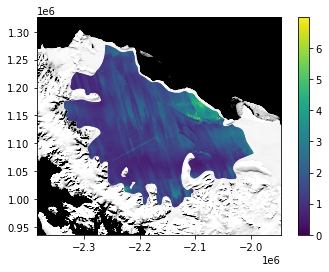

In [8]:
σ = firedrake.interpolate(firedrake.sqrt(σx**2 + σy**2), Q)
fig, axes = subplots()
colors = icepack.plot.tripcolor(σ, vmin=0, axes=axes)
fig.colorbar(colors);

We need to make an initial guess for the fluidity parameter.
In this case, we'll use the same value as in the second demo -- a constant fluidity assuming a temperature of -13C.

In [9]:
T = firedrake.Constant(260)
A0 = icepack.rate_factor(T)

def viscosity(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    θ = kwargs['log_fluidity']
    
    A = A0 * firedrake.exp(θ)
    return icepack.models.viscosity.viscosity_depth_averaged(
        velocity=u, thickness=h, fluidity=A
    )

θ = firedrake.Function(Q)

model = icepack.models.IceShelf(viscosity=viscosity)
opts = {'dirichlet_ids': [2, 4, 5, 6, 7, 8, 9]}
solver = icepack.solvers.FlowSolver(model, **opts)

u = solver.diagnostic_solve(
    velocity=u_obs, 
    thickness=h,
    log_fluidity=θ
)

Let's look at the observed ice velocity and the computed of the ice velocity starting from our assumption that the fluidity is constant in space.

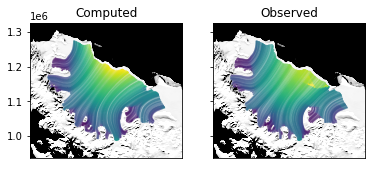

In [10]:
fig, axes = subplots(ncols=2, sharex=True, sharey=True)
for ax in axes:
    ax.get_xaxis().set_visible(False)
kwargs = {'precision': 1000, 'density': 2500, 'vmin': 0, 'vmax': 750}
axes[0].set_title('Computed')
axes[1].set_title('Observed')
icepack.plot.streamplot(u, axes=axes[0], **kwargs)
icepack.plot.streamplot(u_obs, axes=axes[1], **kwargs);

There are a few obvious missing features in our initial computed solution.
For example, in this data, there's still a rift emanating from the Gipps Ice Rise.
(In 2017, that rift finished propagating all the way across the terminus and broke off [Iceberg A-68](https://en.wikipedia.org/wiki/Iceberg_A-68).)
Our initial computed velocity is smooth, but the observed velocity has a kink going across the rift.
The objective of the exercise that follows is to compute a fluidity field that will reproduce features like the kink in the velocity pattern that emerges as a result of features like rifts.

### Inferring the fluidity

There are four parts that go into an inverse problem:

* a physics model
* an initial guess for the parameter and state
* an error metric
* a smoothness metric

We already have the physics model and some initial guesses.
The next step is to write a pair of Python functions that will create the model-data misfit functional and the regularization functional.
We'll pass these functions to the inverse problem when we create it.

In [11]:
import icepack.inverse

def objective(u):
    δu = u - u_obs
    return 0.5 * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx

Θ = firedrake.Constant(1.)
L = firedrake.Constant(7.5e3)
def regularization(θ):
    return 0.5 * (L / Θ)**2 * inner(grad(θ), grad(θ)) * dx

Now we create the `InverseProblem` object.
We've already mentioned several objects that the inverse problem needs -- the model, the initial guess, some functionals, etc.
Additionally, it needs to know the name of the observed field and the parameter (the `state_name` and `parameter_name`) arguments, since these values are passed to the forward solver as keyword arguments.

The inverse solver will take this information and create a flow solver under the hood for us, but to do so it might need more information than we've already supplied.
First, the keyword argument `solver_kwargs` takes a dictionary of additional keyword arguments to pass when initializing the flow solver, such as Dirichlet IDs or tolerances.
Second, any additional arguments to the diagnostic solve procedure are passed in the dictionary `diagnostic_solve_kwargs`.
In our case, that consists of just the thickness field.

In [12]:
inverse_problem = icepack.inverse.InverseProblem(
    model=model,
    objective=objective,
    regularization=regularization,
    state_name='velocity',
    state=u,
    parameter_name='log_fluidity',
    parameter=θ,
    solver_kwargs=opts,
    diagnostic_solve_kwargs={'thickness': h}
)

Once we've created the problem, we then create a solver object that will iteratively search for a good value of the parameters.
The inverse solver has lots of moving parts, all of which are wrapped in a class that inherits from `icepack.inverse.InverseSolver`.
In our case, we'll be using the Gauss-Newton method, which is implemented in `GaussNewtonSolver`.
Using this class should save you from worrying about too many low-level details, but still provide a good amount of flexibility and transparency.

As a convenience, the inverse solver can take in a function that it will call at the end of every iteration.
For this demonstration, we'll have it print out the values of the misfit and regularization functionals and the expected decrease in the sum of those two functionals.
The expected decrease in $J$ can be calculated as

$$\Delta = \langle dJ, q\rangle,$$

where $dJ$ is the gradient of $J$ and $q$ is the search direction.
The expected decrease should be negative on every step -- after all, we're trying to find a minimizer of $J$.
If the expected decrease becomes positive, that suggests that we've found a local minimum and no more improvement is possible.
This is an important number to watch because it can tell you whether or not it's worthwhile to take more iterations of the solver.

We've also passed some extra arguments to `assemble` to specify the quadrature rule for calculating the expected decrease.
The assembly routine will default to being very conservative and use a much more accurate quadrature rule than we really need and throw a warning about this behavior.
This step isn't strictly necessary, it's just good practice.

In [13]:
qdegree = model.quadrature_degree(
    velocity=u, thickness=h, log_fluidity=θ
)
params = {'quadrature_degree': qdegree}

area = firedrake.assemble(firedrake.Constant(1) * dx(mesh))
def callback(inverse_solver):
    dJ = inverse_solver.gradient
    q = inverse_solver.search_direction
    dJ_dq = firedrake.action(dJ, q)
    Δ = firedrake.assemble(dJ_dq, form_compiler_parameters=params)

    E = firedrake.assemble(inverse_solver.objective)
    R = firedrake.assemble(inverse_solver.regularization)
    print(f'{E / area:g}, {R / area:g}, {Δ / area:g}')

You could also, say, make a plot of the state and parameter guess at every iteration to make a movie of how the algorithm progresses.
In programming parlance, a function like this is referred to as a *callback*.

To create the solver object, we only need to give it a problem and optionally the callback function.

In [14]:
inverse_solver = icepack.inverse.GaussNewtonSolver(
    inverse_problem, callback, search_max_iterations=300
)

1946.17, 0, -3827.64


As a general principle, it's a good idea to separate out the *specification* of a problem, in this case represented by the `InverseProblem` class, from the method used to solve the problem, represented by the `GaussNewtonSolver` class.
We've already seen this pattern before in how flow models (like `IceShelf`) are distinct from the objects that actually calculate the solutions (`FlowSolver`).

Before setting the solver loose, let's look at the initial search direction.
The search direction is zero throughout most of the ice shelf.
It has strong positive anomalies in the vicinity of the sharp rifts on the grid-east side of the domain.
In other words, starting from a spatially constant initial guess, the fastest way to reduce the model-data misfit would be to make the shelf more fluid in the vicinity of these rifts.

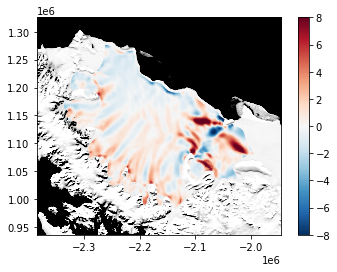

In [15]:
fig, axes = subplots()
ϕ = inverse_solver.search_direction
colors = icepack.plot.tripcolor(
    ϕ, vmin=-8, vmax=+8, cmap='RdBu_r', axes=axes
)
fig.colorbar(colors);

The search direction is obtained by multiplying the inverse of the Gauss-Newton matrix $H$ by the gradient $dJ$ of the objective function.
The Gauss-Newton matrix is dense, so we don't actually build the matrix directly.
Instead, the solver contains a procedure to multiply a vector by $H$, which is all that's necessary for using iterative methods to solve linear systems.
Computing the search direction like this is time-consuming, but results in far fewer iterations, so it's a net win.

The solve method takes in a relative convergence tolerance, an absolute tolerance, and a maximum number of iterations, and it returns the total number of iterations necessary to achieve the given tolerances.
In our case, we'll stop once either (1) the relative decrease in the objective function from one iteration to the next is less than 1/200 or (2) the expected relative decrease in the objective is less than 1/1,000,000.
The relevant tolerances for these are respectively `rtol` and `etol`.
There's also an absolute stopping tolerance `atol`, which we won't use this time.
Absolute stopping tolerances are good for certain statistical problems where you know a priori how good of a fit to the data to expect.

The algorithm takes about 30-45 minutes to run.
Now would be the time to put on a fresh pot of coffee.

In [16]:
iterations = inverse_solver.solve(
    rtol=5e-3,
    etol=1e-6,
    atol=0.0,
    max_iterations=30
)

294.385, 1.98469, -558
40.8821, 3.83318, -58.6561
19.1382, 3.78698, -15.0916
15.0187, 3.89563, -6.68821
11.6032, 4.2469, -1.32558
11.0032, 4.35929, -0.63844
10.7469, 4.43146, -0.309683
10.5344, 4.51104, -0.217981
10.4653, 4.52695, -0.078793


The algorithm converges in just a few iterations because of how good a search direction we get from using the Gauss-Newton approximation.
It's also worth observing how quickly the magnitude of the expected decrease in the objective functional gets reduced on every iteration -- usually by at least a factor of four every time.
Other methods like gradient descent take many more iterations to reach the same agreement with the data.

### Analysis

Now that we're done, we'll want to do some post-processing and analysis on the fluidity parameter that we inferred.
The inverse problem object stores the parameter we're inferring and the observed field as the properties `parameter` and `state` respectively.
The names are intentionally not specific to just ice shelves.
For other problems, we might instead be inferring a friction coefficient rather than a fluidity, or we might be observing the thickness instead of the velocity.
You can see all the publicly visible properties by typing `help(inverse_problem)`.

First, let's plot the parameter values.

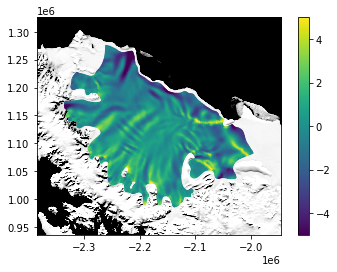

In [17]:
θ = inverse_solver.parameter
fig, axes = subplots()
colors = icepack.plot.tripcolor(
    θ, vmin=-5, vmax=+5, axes=axes
)
fig.colorbar(colors);

The fluidity is much higher around areas of heavy crevassing, such as the rift opening from the Gipps Ice Rise and the area flowing into it.
Additionally, several areas downstream of the inlets have much higher fluidity, and these might indicate the formation of marine ice.

The fluidity is substantially lower around the upper left edge of the ice shelf.
Some of the ice might actually be grounded here, in which case the resulting basal drag would tend to reduce the extensional strain of the glacier.
However, since the only tunable variable for explaining the observed velocities is the fluidity, the algorithm will erroneously converge on whatever value of the fluidity can reproduce the observed values.
In this case, the result is a very low value of $A$, but for other problems the bias can go in the other direction.

To see how well the parameters fit the data, let's look at the weighted difference between the computed and observed velocities.

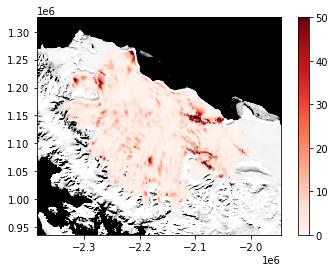

In [18]:
u = inverse_solver.state
fig, axes = subplots()
δu = firedrake.interpolate((u - u_obs)**2/(2*σ**2), Q)
colors = icepack.plot.tripcolor(
    δu, vmin=0, vmax=50, cmap='Reds', axes=axes
)
fig.colorbar(colors);

The computed ice velocity is mostly similar to observations aside from a few blips.
The most widespread departures from observations occur around the rifts that flow into the Gipps Ice Rise.
We regularized the problem by looking only for smooth values of the fluidity parameter.
As a consequence, we won't be able to see sharp changes that might result from features like crevasses or rifts.
We might instead try to use the total variation functional

$$R(\theta) = L\int_\Omega|\nabla\theta|dx$$

if we were interested in features like this.

Finally, let's try and see how much the inferred parameter departed from our naive initial guess.

In [19]:
print(icepack.norm(inverse_solver.parameter) / np.sqrt(area))
print(firedrake.assemble(inverse_solver.objective) / area)

1.53660818716913
10.46530482423144


The model-data misfit has been reduced by two orders of mangitude through the optimization procedure, and our final approximation departs quite substantially from the initial guess.
This suggests that data assimilation does give a substantial benefit over an ad-hoc approach like picking a sensible constant value.

### Conclusion

In this demo, we've shown how to back out the fluidity of an ice shelf from remote sensing observations.
We could then use this value, together with a description of how the fluidity evolves, to initialize a prognostic model of the ice shelf.
For example, we might assume that the fluidity is a function of ice temperature and damage.
The evolution equations for these fields are fairly simple hyperbolic PDE for which we can write solvers using firedrake.

The value of the fluidity that we obtained is not at all spatially homogeneous.
Unless we were very clever, we probably couldn't have come up with some way to parameterize it to get a reasonable guess.

We would expect from statistical estimation theory that the value of the misfit functional divided by the shelf area will be around 1.
(A sum of squares of normal random variables has a $\chi^2$ distribution, which has mean 1, there are two components of the velocity vector, and we divide by 2 at the end.)
The misfit we obtained once the algorithm has converged is much larger than 1.
Why might this happen?

1. We made a poor choice of regularization parameter; the solution is too smooth to fit the data.
2. The regularization parameter is fine, but the error estimates $\sigma$ are wrong.
3. The standard deviations $\sigma$ of the error estimates are correct, but the error distribution is non-normal and has heavier tails.
4. We don't have a good way to also account for thickness errors, which are substantial.
5. The ice shelf is actually grounded on some isolated pinning points or ice rises and we didn't add any basal drag.
6. The model physics don't adequately account for the effects of rifts and crevasses.
7. I implemented the numerical optimization algorithm incorrectly.

Failure modes 1 happens because we don't have the right prior distribution, while modes 2, 3, and 4 occur because we don't have the correct observational likelihood.
Modes 5 and 6 are more insidious types of failure.
In this case, the physics model doesn't actually describe the true behavior of the system.
This might mean that the model cannot reproduce the observations with *any* value of the input data.
That kind of failure is difficult to miss.
But some wrong physics models -- those that are [controllable](https://en.wikipedia.org/wiki/Controllability) as a function of the input parameters -- might still be able to reproduce the observations.
The catch is that they will "explain" the data however they can, even if the reasons are wrong!
Diagnosing this type of failure is arguably the most difficult.
Last but not least is human error in implementing the optimization algorithms.
These kinds of failures should be caught through testing on synthetic problems.